In [1]:
import scanpy as sc
import schist as scs
import pandas as pd
import anndata as ad
import sklearn.metrics
import pynndescent
%pylab
%matplotlib inline

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [2]:
sc.settings.verbosity=2
sc.set_figure_params(dpi=80, dpi_save=300)

In [3]:
adata1 = scs.io.read("10XV3_075")
adata2 = scs.io.read("Quartzseq_075")

/Users/cittaro.davide/anaconda3/envs/experimental/lib/python3.8/site-packages/graph_tool/inference/blockmodel.py:387: UserWarning: unrecognized keyword arguments: ['sampling']
  warnings.warn("unrecognized keyword arguments: " +


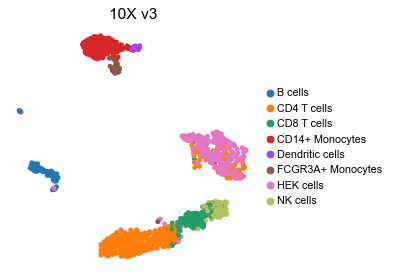

In [4]:
sc.pl.umap(adata1, color='nnet2', #legend_loc='on data', 
           frameon=False, title='10X v3', 
           save='10x_v3_annotation.png', legend_fontsize='x-small')

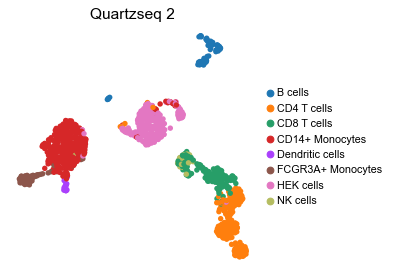

In [5]:
sc.pl.umap(adata2, color='nnet2', #legend_loc='on data', 
           frameon=False, title='Quartzseq 2', 
           save='Quartzseq_annotation.png', legend_fontsize='x-small')

In [6]:
adata1.obs['annotation'] = adata1.obs['nnet2']
adata2.obs['annotation'] = 'Unknown'

In [22]:
mdata = adata1.concatenate(adata2, batch_categories=['10XV3', 'Quartzseq'])
mdata.obs['annotation'] = pd.Categorical(mdata.obs['annotation'])

In [23]:
cells = mdata.obs.query('(nnet2 != "CD4 T cells" and batch == "Quartzseq") or (batch == "10XV3")').index

In [24]:
sc.pp.scale(mdata)
sc.tl.pca(mdata)
sc.external.pp.harmony_integrate(mdata, key='batch')

computing PCA
    on highly variable genes
/Users/cittaro.davide/anaconda3/envs/experimental/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
    with n_comps=50
    finished (0:00:02)
2021-07-16 12:27:48,529 - harmonypy - INFO - Iteration 1 of 10
2021-07-16 12:27:49,230 - harmonypy - INFO - Iteration 2 of 10
2021-07-16 12:27:49,924 - harmonypy - INFO - Iteration 3 of 10
2021-07-16 12:27:50,514 - harmonypy - INFO - Iteration 4 of 10
2021-07-16 12:27:51,183 - harmonypy - INFO - Iteration 5 of 10
2021-07-16 12:27:51,887 - harmonypy - INFO - Iteration 6 of 10
2021-07-16 12:27:52,249 - harmonypy - INFO - Iteration 7 of 10
2021-07-16 12:27:53,642 - harmonypy - INFO - Iteration 8 of 10
2021-07-16 12:27:54,064 - harmonypy - INFO - Iteration 9 of 10
2021-07-16 12:27:54,427 - harmonypy - INFO - Converged a

In [25]:
#mdata = mdata[cells]
sc.pp.neighbors(mdata, n_neighbors=int(np.sqrt(mdata.shape[0])/2), use_rep='X_pca_harmony')
#sc.tl.umap(mdata)

computing neighbors
    finished (0:00:00)


In [26]:
scs.tl.calculate_affinity(mdata, group_by='annotation', neighbors_key='neighbors')

Calculating cell affinity to annotation


In [27]:
categories = mdata.obs['annotation'].cat.categories
affinity = pd.DataFrame(mdata.obsm['CA_annotation'], index=mdata.obs_names, 
                        columns=categories)

In [28]:
rank_affinity = affinity.rank(axis=1, ascending=False)
#rank_affinity = affinity[adata1.obs['nnet2'].cat.categories].rank(axis=1, ascending=False)
mdata.obs['reassigned'] = mdata.obs['annotation'].values
for c in rank_affinity.columns:
    cells = rank_affinity[rank_affinity[c] == 1].index
    mdata.obs.loc[cells, 'reassigned'] = c

In [29]:
mdata_1 = mdata[mdata.obs['batch'] == "10XV3"]
mdata_2 = mdata[mdata.obs['batch'] != "10XV3"]
mdata_1.obs_names = [x.replace('-10XV3', '') for x in mdata_1.obs_names]
mdata_2.obs_names = [x.replace('-Quartzseq', '') for x in mdata_2.obs_names]
n_neighbors = int(np.sqrt(mdata_1.shape[0])/2)
knn = pynndescent.NNDescent(mdata_1.obsm['X_pca_harmony'], n_neighbors=n_neighbors)
closest = knn.query(mdata_2.obsm['X_pca_harmony'], k=1)[0]

/Users/cittaro.davide/anaconda3/envs/experimental/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [30]:
mdata_2.obs['knn_label'] = mdata_1.obs['annotation'].iloc[closest.ravel()].values

In [31]:
adata2.obs['reassigned_schist'] = mdata_2.obs['reassigned']
adata2.obs['reassigned_knn'] = mdata_2.obs['knn_label']

In [32]:
col_scheme = dict(zip(adata2.obs['nnet2'].cat.categories, adata2.uns['nnet2_colors']))

col_scheme['Unknown'] = '#AABBCC'

In [33]:
adata2.uns['reassigned_schist_colors'] = [col_scheme[x] for x in adata2.obs['reassigned_schist'].cat.categories]
adata2.uns['reassigned_knn_colors'] = [col_scheme[x] for x in adata2.obs['reassigned_knn'].cat.categories]

In [34]:
adata2.obs['reassigned_knn']

QUARTZseq_P4S7_AACACCTCGACTCCG    CD14+ Monocytes
QUARTZseq_P4S7_AACCATTAGCAGGAA    CD14+ Monocytes
QUARTZseq_P4S7_AACCGATCAAGTCAA        CD4 T cells
QUARTZseq_P4S7_AACCGCACATAGCGG        CD4 T cells
QUARTZseq_P4S7_AACCGTCGCACCTCT            B cells
                                       ...       
QUARTZseq_P5S8_TTGAACGTTGCTTGG        CD4 T cells
QUARTZseq_P5S8_TTGATACTTCACTCG        CD4 T cells
QUARTZseq_P5S8_TTGCCTCCTTATCGC        CD4 T cells
QUARTZseq_P5S8_TTGGCAACTCTATGA        CD4 T cells
QUARTZseq_P5S8_TTGGCTTGCGGCACA        CD4 T cells
Name: reassigned_knn, Length: 1266, dtype: category
Categories (8, object): ['B cells', 'CD14+ Monocytes', 'CD4 T cells', 'CD8 T cells', 'Dendritic cells', 'FCGR3A+ Monocytes', 'HEK cells', 'NK cells']

In [35]:
truth = adata2.obs.dropna()['nnet2'][adata2.obs['reassigned_schist'] != 'Unknown']
test = adata2.obs.dropna()['reassigned_schist'][adata2.obs['reassigned_schist'] != 'Unknown']
acc_schist = sklearn.metrics.accuracy_score(truth, test)

truth = adata2.obs.dropna()['nnet2'][adata2.obs['reassigned_knn'] != 'Unknown']
test = adata2.obs.dropna()['reassigned_knn'][adata2.obs['reassigned_knn'] != 'Unknown']
acc_knn = sklearn.metrics.accuracy_score(truth, test)

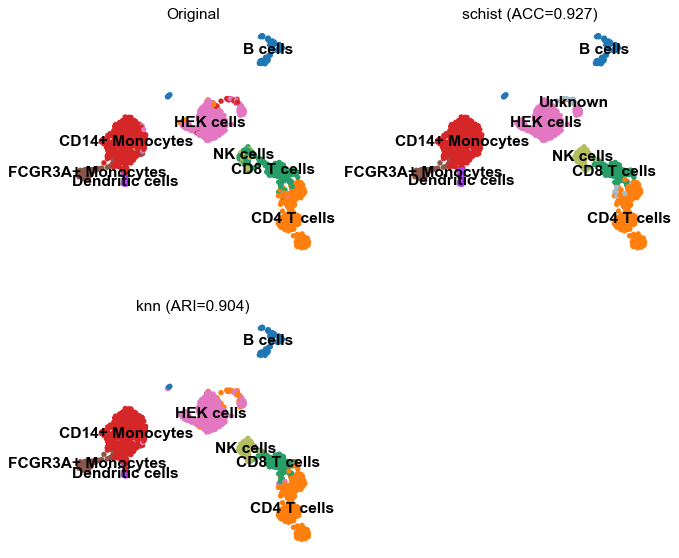

In [36]:
sc.pl.umap(adata2, color=['nnet2', 'reassigned_schist', 'reassigned_knn'], ncols=2, 
          title=['Original', f'schist (ACC={acc_schist:.3f})', f'knn (ARI={acc_knn:.3f})'],
           legend_loc='on data', frameon=False)

In [22]:
col_scheme

{'B cells': '#1f77b4',
 'CD4 T cells': '#ff7f0e',
 'CD8 T cells': '#279e68',
 'CD14+ Monocytes': '#d62728',
 'Dendritic cells': '#aa40fc',
 'FCGR3A+ Monocytes': '#8c564b',
 'HEK cells': '#e377c2',
 'NK cells': '#b5bd61',
 'Unknown': '#AABBCC'}

In [23]:
adata2.uns['reassigned_schist_colors']

['#1f77b4',
 '#d62728',
 '#ff7f0e',
 '#279e68',
 '#aa40fc',
 '#8c564b',
 '#e377c2',
 '#b5bd61',
 '#AABBCC']

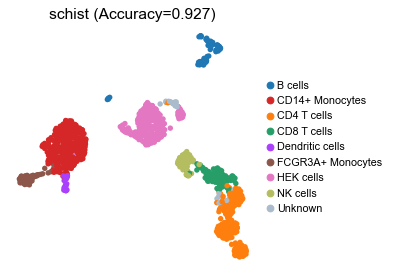

In [37]:
sc.pl.umap(adata2, color='reassigned_schist', 
          title=f'schist (Accuracy={acc_schist:.3f})',
           #legend_loc='on data', 
           frameon=False, 
           legend_fontsize='x-small', save='label_schist_q.png')

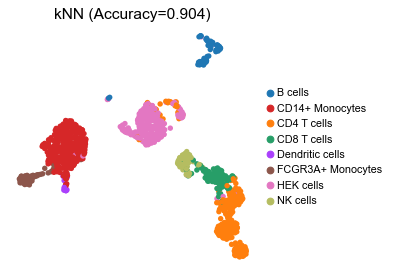

In [38]:
sc.pl.umap(adata2, color='reassigned_knn', 
          title=f'kNN (Accuracy={acc_knn:.3f})',
           #legend_loc='on data', 
           frameon=False, 
           legend_fontsize='x-small', save='label_knn_q.png')

In [24]:
unassigned = adata2.obs.query('reassigned_schist == "Unknown"')[['nnet2', 'reassigned_knn']]

unassigned.index = [f'{x}-Quartzseq' for x in unassigned.index]

unassigned_ranks = []
for cell in unassigned.index:
    truth = unassigned.loc[cell, 'nnet2']
    try:
        unassigned_ranks.append(rank_affinity.loc[cell, truth])
    except KeyError:
        continue

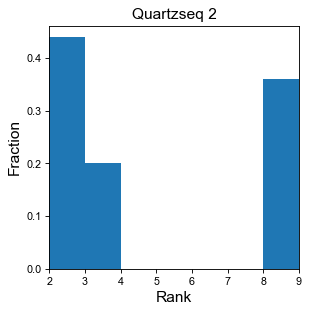

In [25]:
hist(unassigned_ranks, bins=range(1, 10), density=True)
grid()
xlim(2, 9)
xticks(range(2, 10), fontsize='x-small')
yticks(np.arange(0, 0.41, 0.1), fontsize='x-small')
xlabel("Rank")
ylabel("Fraction")
title("Quartzseq 2")
savefig("figures/hist_label_second_q.png")

In [26]:
sklearn.metrics.accuracy_score(adata2.obs['nnet2'], adata2.obs['reassigned_schist'])

0.9091627172195893

In [27]:
truth = adata2.obs['nnet2'][adata2.obs['reassigned_schist'] != 'Unknown']
test = adata2.obs['reassigned_schist'][adata2.obs['reassigned_schist'] != 'Unknown']
sklearn.metrics.accuracy_score(truth, test)

truth = adata2.obs['nnet2'][adata2.obs['reassigned_knn'] != 'Unknown']
test = adata2.obs['reassigned_knn'][adata2.obs['reassigned_knn'] != 'Unknown']
sklearn.metrics.accuracy_score(truth, test)

0.9036334913112164

In [28]:
adata2.obs['reassigned_schist'].value_counts(normalize=True)

CD14+ Monocytes      0.281991
CD4 T cells          0.234597
HEK cells            0.191153
CD8 T cells          0.089258
NK cells             0.060032
B cells              0.058452
FCGR3A+ Monocytes    0.047393
Unknown              0.019747
Dendritic cells      0.017378
Name: reassigned_schist, dtype: float64

### Also try ingest

In [39]:
adata_r = adata1[:, mdata.var_names]
adata_q = adata2[:, mdata.var_names]
adata_q.obs['nnet2_original'] = adata_q.obs['nnet2']

/Users/cittaro.davide/anaconda3/envs/experimental/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.obs` of view, copying.


In [40]:
sc.tl.ingest(adata_q, adata_r, obs='nnet2')

running ingest
    finished (0:00:14)


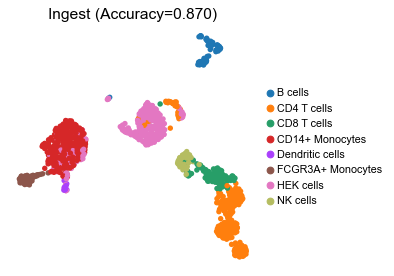

In [41]:
adata2.obs['ingest'] = adata_q.obs['nnet2']
truth = adata2.obs['nnet2']
test = adata2.obs['ingest']
acc_ing = sklearn.metrics.accuracy_score(truth, test)
sc.pl.umap(adata2, color='ingest', 
          title=f'Ingest (Accuracy={acc_ing:.3f})',
           #legend_loc='on data', 
           frameon=False, 
           legend_fontsize='x-small', save='label_ing_q.png')

In [42]:
scs.io.write(adata2, 'Quartz_reassigned')